In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible
from splinedist import fill_label_holes

from splinedist import random_label_cmap, _draw_polygons, export_imagej_rois
from splinedist.models import SplineDist2D
from splinedist.utils import iou_objectwise, iou 

np.random.seed(6)
lbl_cmap = random_label_cmap()

import os
os.environ['CUDA_VISIBLE_DEVICES']=''

# Data

We assume that data has already been downloaded in via notebook [1_data.ipynb](1_data.ipynb).  
We now load images from the sub-folder `test` that have not been used during training.

In [2]:
X = sorted(glob('data/dsb2018/test/images/*.tif'))
X = list(map(imread,X))

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

In [3]:
# show all test images
if False:
    fig, ax = plt.subplots(7,8, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

# Load trained model

In [4]:
model = SplineDist2D(None, name='splinedist_6', basedir='models')

Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.


# Prediction

In [5]:
img = normalize(X[16], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)

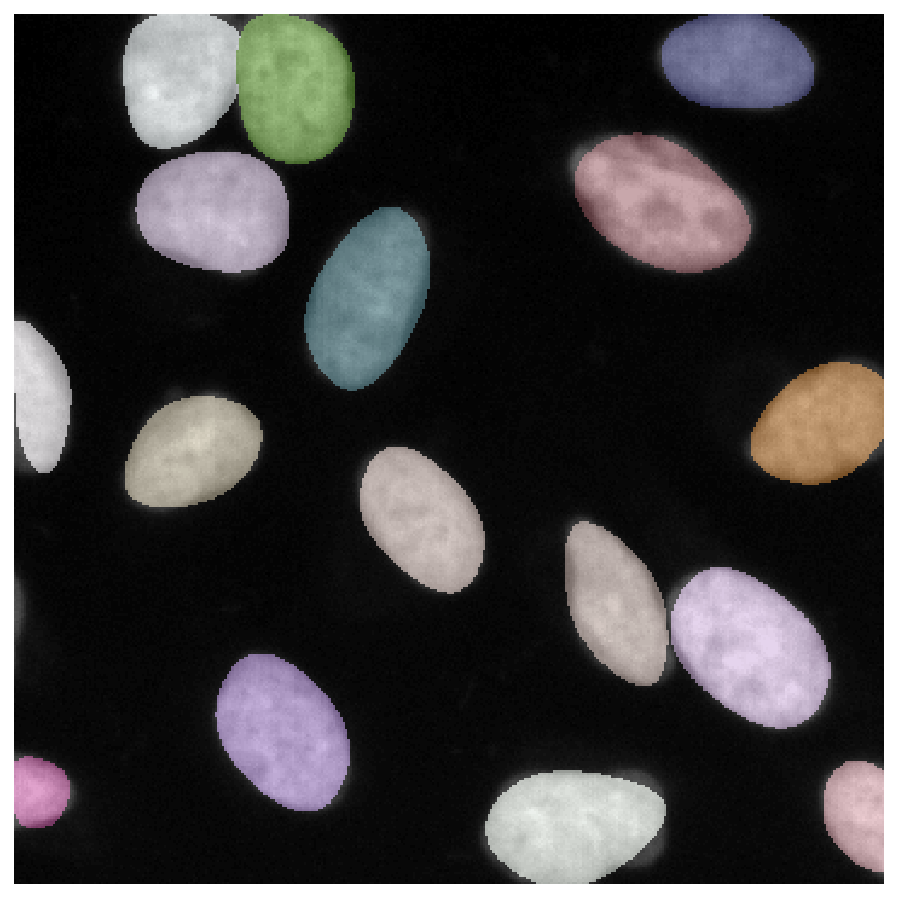

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');

# Example results

In [7]:
def example(model, i, show_dist=True):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,0]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

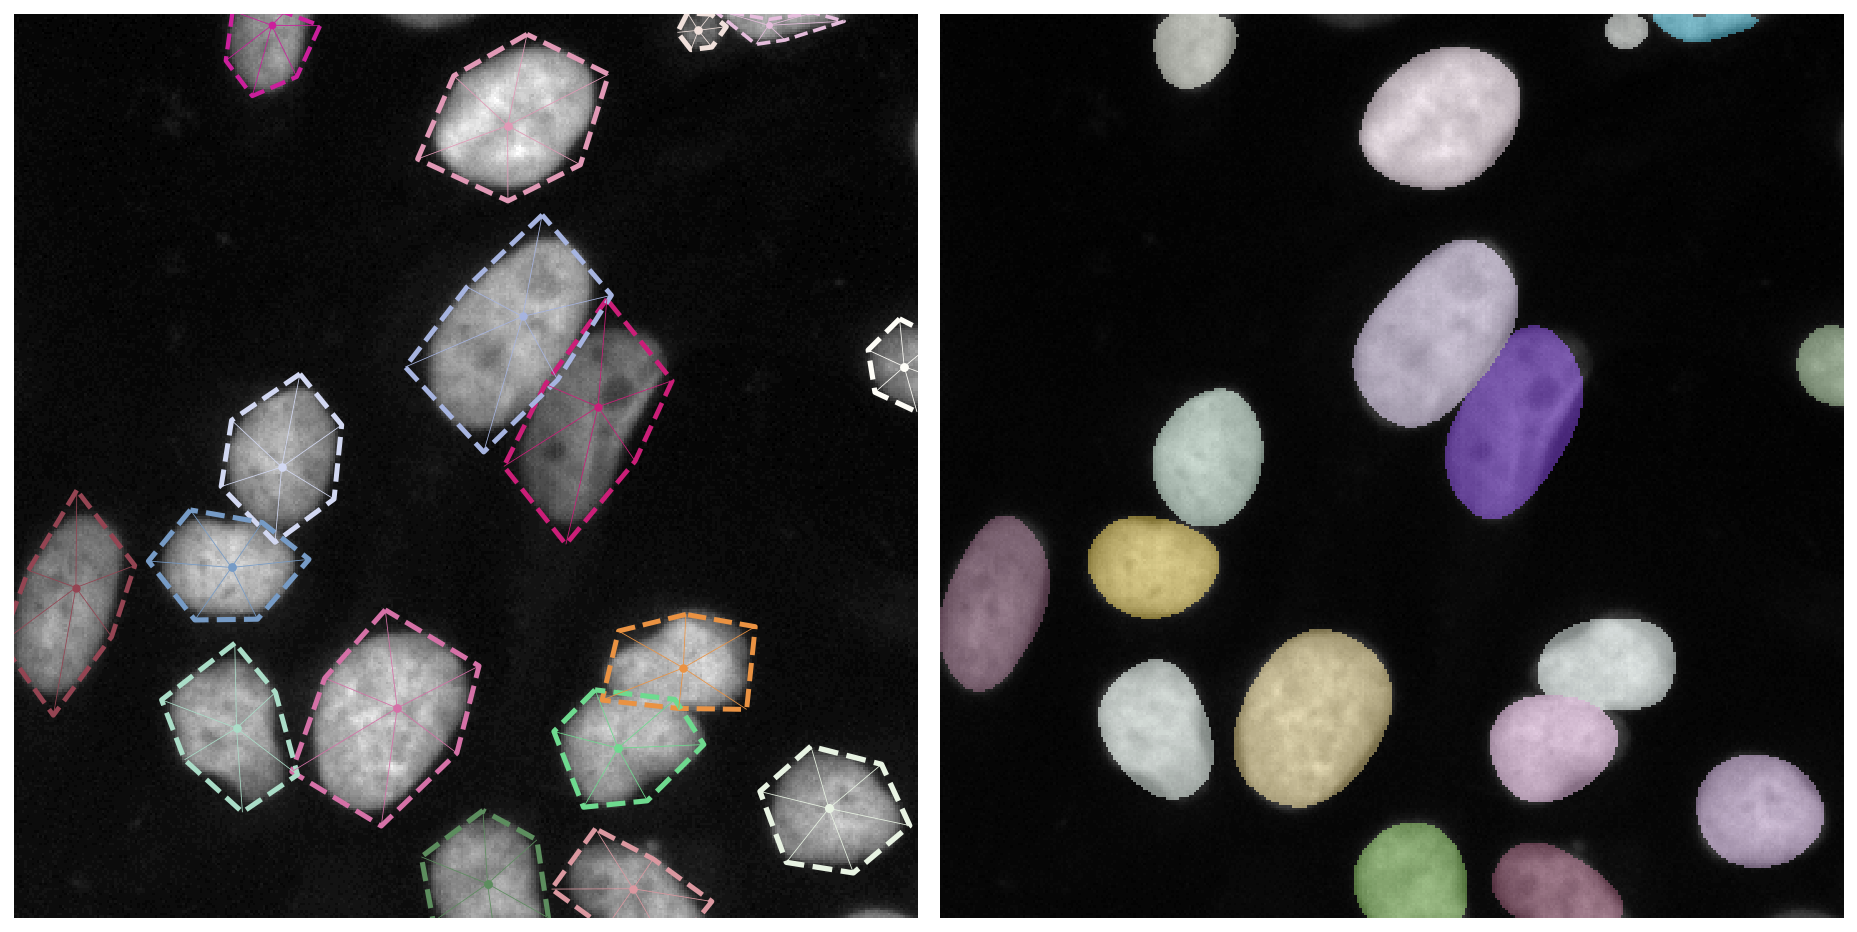

In [8]:
example(model, 42)

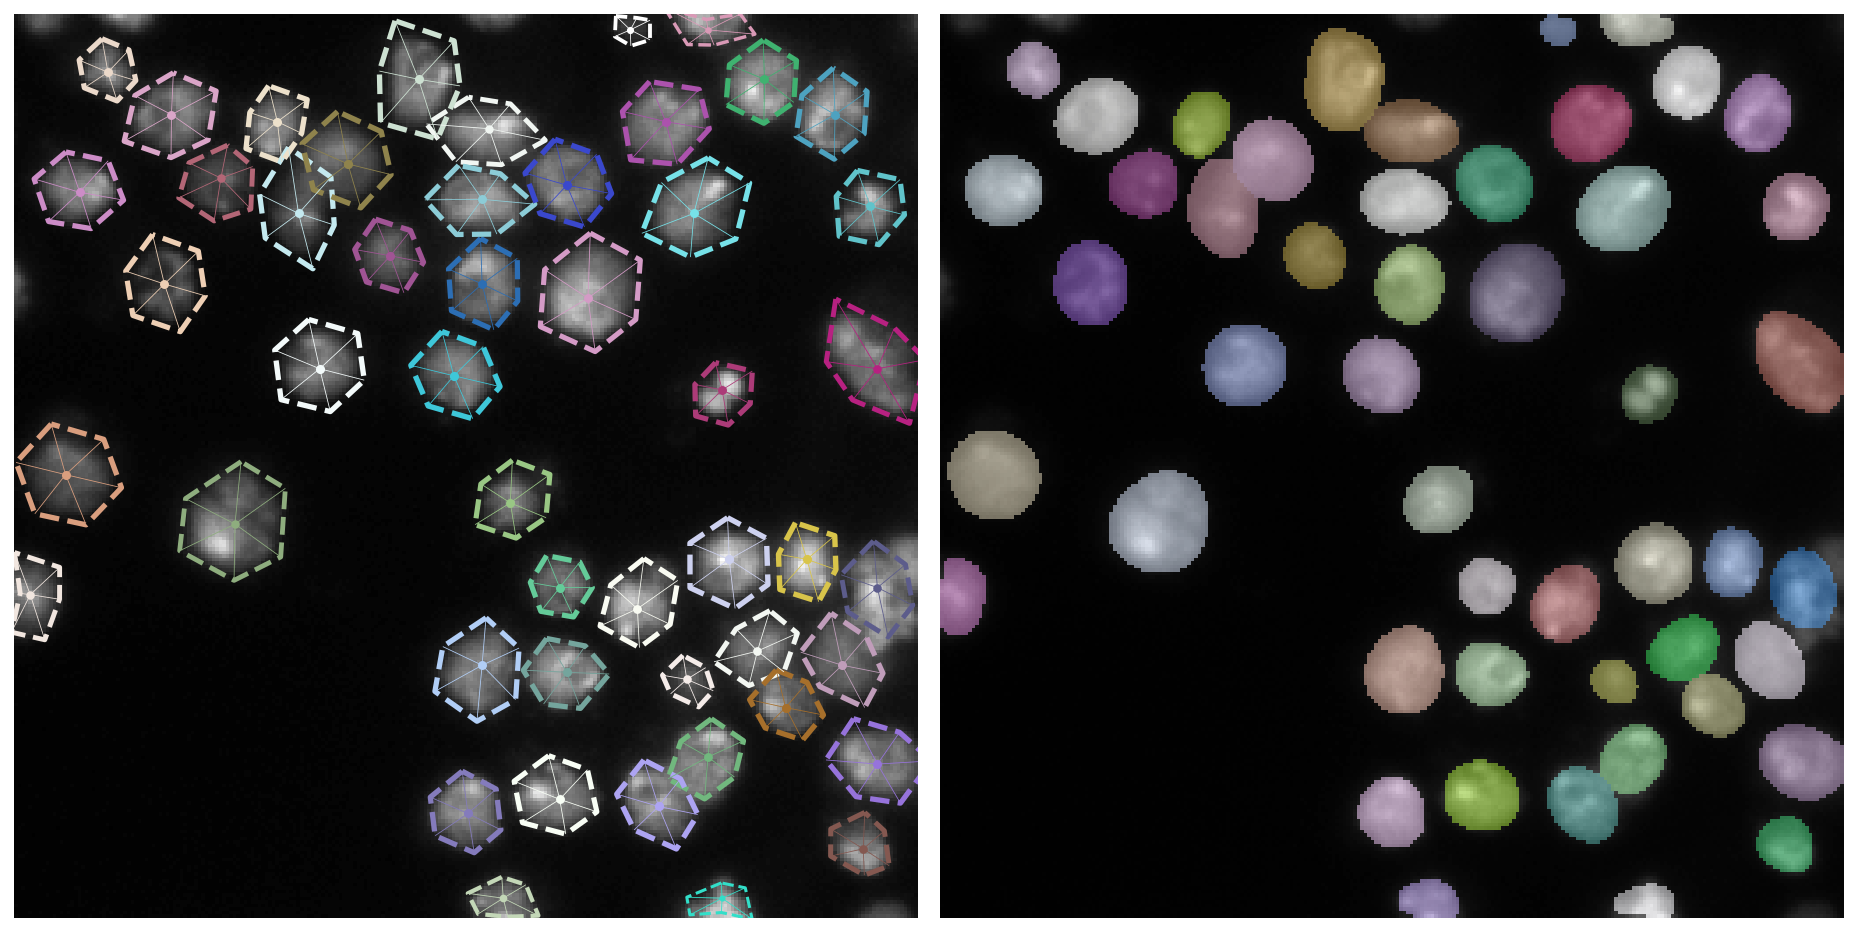

In [9]:
example(model, 1)

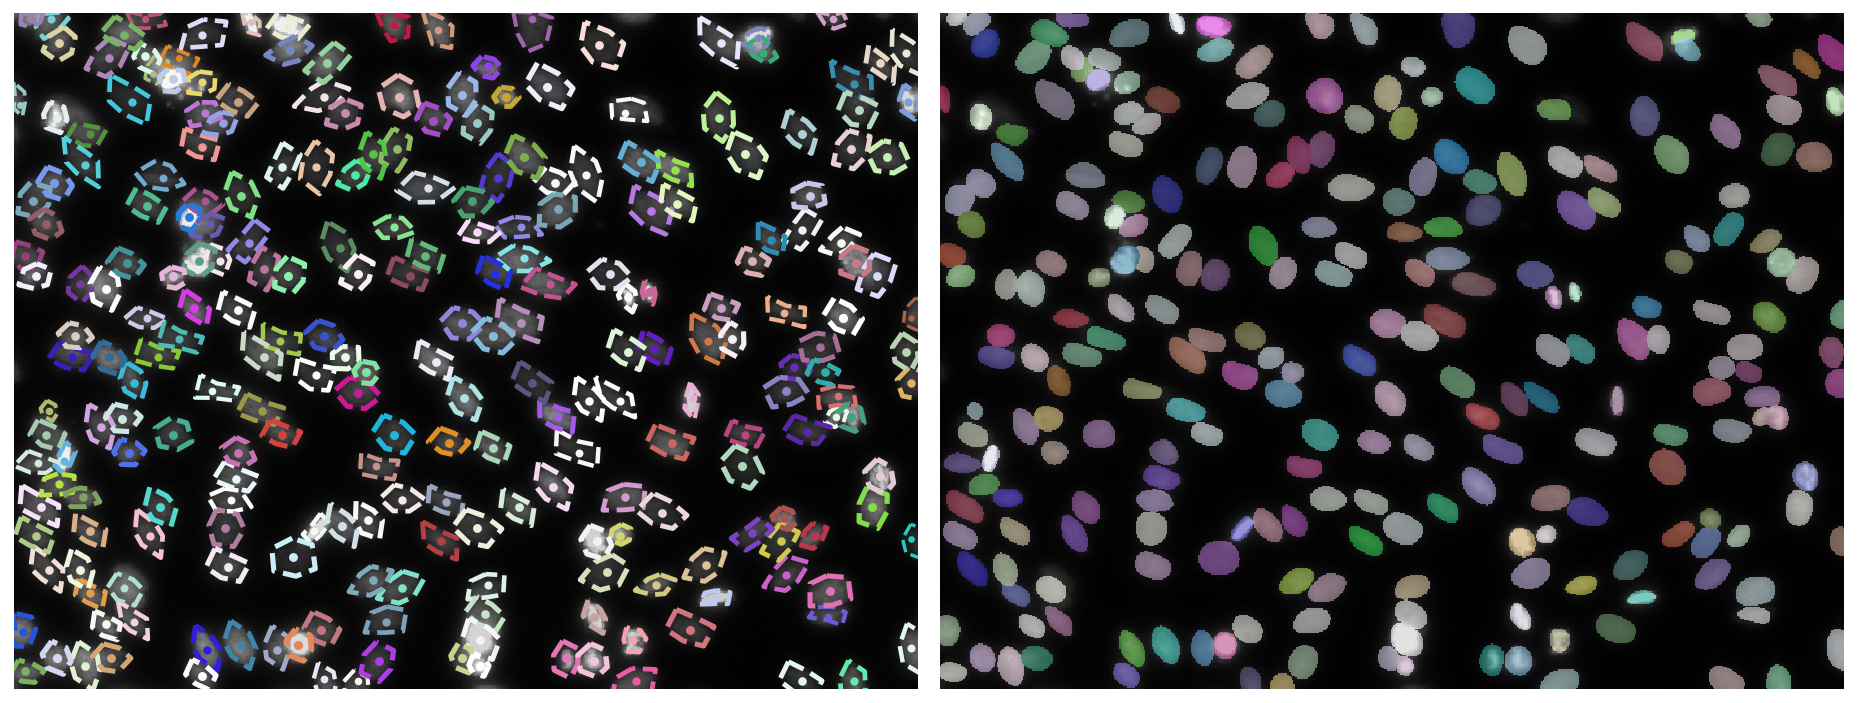

In [10]:
example(model, 15, False)

# Metric Computation 

In [11]:
X = sorted(glob('data/dsb2018/test/images/*.tif'))
Y = sorted(glob('data/dsb2018/test/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

X = list(map(imread,X))
Y = list(map(imread,Y))

axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in X]
Y = [fill_label_holes(y) for y in Y]

In [12]:
Y_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in X]

In [13]:
iou_list = np.asarray(iou(Y,Y_pred))

In [14]:
np.mean(iou_list), np.std(iou_list)

(0.8297314077029431, 0.06586403989535214)